In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io
import json

In [2]:
#%% Optional graphics settings for interactive plotting
#from IPython import get_ipython
#get_ipython().run_line_magic('matplotlib', 'qt')

In [3]:
#%% Paths
# If the dataset has the same structure as on Box, only base_data_dir needs to be changed
base_data_dir = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Hyperspectral'

transect_dir = os.path.join(base_data_dir,'Transects/Transect1-15m-AGL')
trans1_rrs_file = os.path.join(transect_dir,'R_rs','manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-ReflectivityConversionFromRadiance.bip.hdr')

annotation_dir = os.path.join(transect_dir,'Annotation')
ann_classes_json = os.path.join(annotation_dir,'label_classes.json')
ann_trans1_im = os.path.join(annotation_dir,'transect1_radiance_rgb_15mAGL.png')

In [4]:
#%% Constants / input parameters
rbg_default = (640, 550, 460)   # Default wavelengths for RGB display


In [5]:
#%% Import image
im = spectral.io.envi.open(trans1_rrs_file) 
# Dimensions of image are (height / nrows, width / ncols, nbands)
# Note that the spectral library does not load the whole image into memory immediately,
# to save memory. When indexing slices of the full cube, only the slices are read.

In [6]:
#%% Convert relevant metadata
# Read wavelengths
wl = np.array([float(i) for i in im.metadata['wavelength']])

# Get indices for standard RGB render
rgb_ind = tuple((np.abs(wl - value)).argmin() for value in rbg_default)

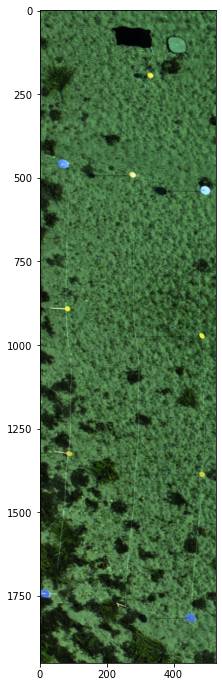

In [7]:
#%% Show image (using spectral version of imshow)
view = spectral.imshow( data=im,bands=rgb_ind, figsize=(6,12))

In [10]:
#%% Contrast stretching on RGB render
im_rgb = im[:,:,rgb_ind]
im_rgb_rescale = np.zeros(im_rgb.shape)
p2,p98 = np.percentile(im_rgb, (2,98))
im_rgb_rescale = exposure.rescale_intensity( im_rgb, in_range=(p2, p98))

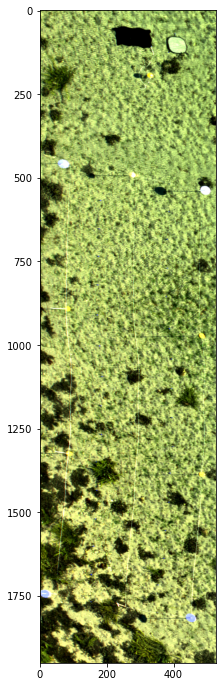

In [11]:
#%% Show contrast stretched image (with "regular" imshow)
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow( im_rgb_rescale)

Text(0, 0.5, '$R_{rs}$')

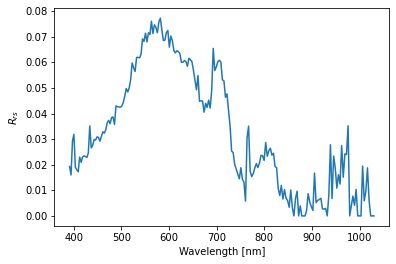

In [12]:
#%% Plot example spectrum
ex_spec = np.squeeze(im[900,400,:]) # Pixel in area with seagrass
plt.plot(wl,ex_spec)
plt.xlabel('Wavelength [nm]')
plt.ylabel('$R_{rs}$')

In [13]:
#%% Load annotation class info from JSON file
# Read raw text
with open(ann_classes_json, 'r') as myfile:
    data=myfile.read()

# Parse JSON text into list
ann_class_info = json.loads( data)

In [14]:
#%% Show how annotation info is structured
print('Annotation info is ' + str(type(ann_class_info)) + 
      ' with ' + str(len(ann_class_info)) + ' elements, one for each class. \n')

print('The first element is ' + str(type(ann_class_info[0])) + ' and its contents are: \n')
print(ann_class_info[0],sep='\n')

print('\n The name of the first class is ' + ann_class_info[0]['name'] +
     ' and its index in the PNG image is ' + str(ann_class_info[0]['png_index']))

Annotation info is <class 'list'> with 16 elements, one for each class. 

The first element is <class 'dict'> and its contents are: 

{'id': 'b964a902-4a03-41d6-a9f2-7665718966d2', 'color': '#627b454d', 'png_index': 1, 'name': 'Seagrass-0-25%-density', 'type': 'background'}

 The name of the first class is Seagrass-0-25%-density and its index in the PNG image is 1


In [15]:
#%% Build a simple dictionary with class numbers and names
class_dict = {}
for element in ann_class_info:
    class_dict[element['name']] = element['png_index']

In [16]:
#%% Print class dictionary
for key,value in class_dict.items():
    print(key + ' : ' + str(value))

Seagrass-0-25%-density : 1
Seagrass-25-50%-density : 2
Rock(s) : 3
Fucus-vesiculosus : 4
Green algae : 5
Ascophyllum-nodosum : 6
Fucus serratus : 7
Sand : 8
Blue mussels : 9
White-rope : 10
Bamboo-stick : 11
Blue-marker : 12
Red-marker : 13
Yellow-marker : 14
Gray-reference : 15
Black-reference : 16


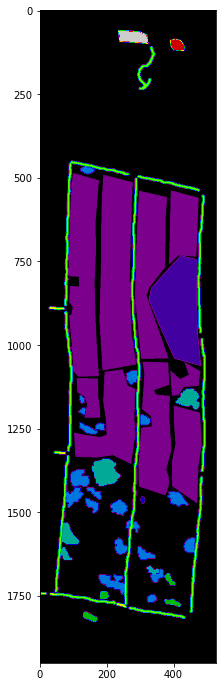

In [17]:
#%% Read and show class PNG file
class_mask = io.imread(ann_trans1_im)
class_mask = np.flip(class_mask,(0,1))    # Annotation image was rotated 180 deg, rotate back

fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(class_mask,cmap='nipy_spectral')

/home/mha114/miniconda3/envs/massimal/lib/python3.9/site-packages/spectral/graphics/spypylab.py:904: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


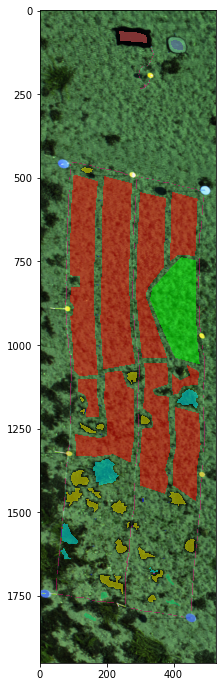

In [18]:
#%% Show hyperspectral image with classes overlaid (note: different colormap for classes)
view = spectral.imshow(data=im,
                       bands=rgb_ind,
                       classes = class_mask,
                       figsize=(6,12))
view.set_display_mode('overlay')

In [19]:
#%% Create boolean mask for single class (Ascophyllum nodosum)
asc_mask = (class_mask == class_dict['Ascophyllum-nodosum']) 

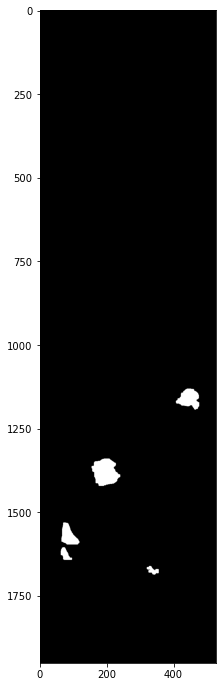

In [20]:
#%% Show boolean mask
fig,ax = plt.subplots(figsize=(6,12))
plt.imshow(asc_mask,cmap = 'gray')

In [21]:
#%% Load whole image into memory, cast as "regular" NumPy array
# (Boolean indexing doesn't work with "spectral" image objects)
im_full = np.array(im.load())

In [22]:
#%% Extract spectra from Ascophyllum mask
asc_spec = im_full[asc_mask]

Text(0.5, 0, 'Wavelength [nm]')

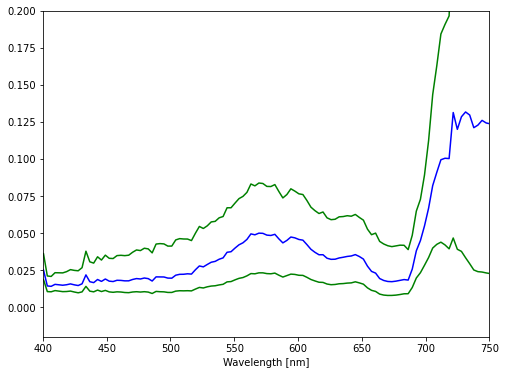

In [23]:
#%% Compute mean and quartiles
asc_spec_mean = asc_spec.mean(axis=0)
asc_spec_q = np.percentile(asc_spec,(5,95),axis=0)

fig,ax = plt.subplots(figsize=(8,6))
plt.plot(wl,asc_spec_mean,'b')
plt.plot(wl,asc_spec_q[0,:],'g')
plt.plot(wl,asc_spec_q[1,:],'g')

plt.xlim([400,750])
plt.ylim([-0.02,0.20])
plt.xlabel('Wavelength [nm]')
